In [1]:
import numpy as np
import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import os, sys, glob, requests
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, timedelta
from metpy.plots import USCOUNTIES
from collections import Counter

#Plot mPING p-type reports
#Written by Massey Bartolini, last updated 4 March 2022

In [2]:
#**********
#Setup variables
var_name = 'mping' #used in plot filename

api_key = '96edae02d51f0bf079e7fee0974837c3908f9e9e'
#**********

imgdir = f'images/{var_name}/' #location to save images
if not os.path.exists(imgdir):
    os.makedirs(imgdir)
#imgdir = '' #uncomment to save in current directory

In [3]:
def plot_geog_single(plot_region, fig = None, ax = None, geog_color='k', geog_lw=2., plot_lakes = 'outline'):
    """Helper function for plotting cartopy geography on an axis
    Inputs: plot_region, geog_color, geog_lw (linewidth), plot_lakes (outline, filled, both, none)
    Returns: fig, ax with geography plotted"""
    #Download and plot states and coastlines
    
    if fig == None and ax == None:
        #create figure if not already generated and passed to function
        #select projection to plot given specified plot_region
        if plot_region == 'conus':
            #CONUS plot using HRRR domain extent
            hrrr_proj = ccrs.LambertConformal(central_longitude = -97.5, central_latitude = 38.5,
                                        standard_parallels = (38.5, 38.5)) #native HRRR projection
        elif plot_region in ['midatl', 'seus']:
            custom_proj = ccrs.LambertConformal(central_longitude = -79) #Mid-Atlantic projection
        elif plot_region == 'carolinas':
            custom_proj = ccrs.LambertConformal(central_longitude = -80.5) #Carolinas projection
        elif plot_region == 'msoh_vly':
            custom_proj = ccrs.LambertConformal(central_longitude = -91) #MS/OH Valley projection
        elif plot_region == 'central':
            custom_proj = ccrs.LambertConformal(central_longitude = -95) #Central Plains projection
        elif plot_region == 'cascades':
            custom_proj = ccrs.LambertConformal(central_longitude = -120.5) #WA/OR projection
        elif plot_region in ['neus','ny']:
            custom_proj = ccrs.LambertConformal(central_longitude = -75) #NY/NEUS projection
        elif plot_region == 'new_england':
            custom_proj = ccrs.LambertConformal(central_longitude = -70.5) #New England projection
        elif plot_region == 'adk_lch_qc':
            #WINTRE-MIX domain plots
            custom_proj = ccrs.LambertConformal(central_longitude = -74) #ADK projection

        if plot_region == 'conus':
            fig, ax = plt.subplots(figsize = (12,9), dpi = 120, subplot_kw = {'projection': hrrr_proj}, facecolor = 'white')
        else:
            fig, ax = plt.subplots(figsize = (12,9), dpi = 120, subplot_kw = {'projection': custom_proj}, facecolor = 'white')
    
    #Options: 10m, 50m, 110 m (fine, medium, coarse)
    if plot_region in ['adk_lch_qc']:
        #geog_scale='10m' #higher-res not working well for some regions
        geog_scale='50m'
    else:
        geog_scale='50m'

    if plot_region in ['olympics','olympics_zoom','cascades','adk_lch_qc','midatl','carolinas']:
        if plot_region == 'adk_lch_qc': county_lw, county_scale = 1.0, '5m'
        else: county_lw, county_scale = 0.5, '20m'
        ax.add_feature(USCOUNTIES.with_scale(county_scale),edgecolor='0.5',zorder=3.0, linewidth = county_lw) #US counties
 
    ax.add_feature(cfeature.OCEAN.with_scale(geog_scale),edgecolor='face',facecolor=cfeature.COLORS['water'])
    ax.add_feature(cfeature.LAND.with_scale(geog_scale),edgecolor='face',facecolor=cfeature.COLORS['land'])
    ax.add_feature(cfeature.BORDERS.with_scale(geog_scale),linewidth=geog_lw,edgecolor=geog_color,zorder=3.1,linestyle='--')
    ax.add_feature(cfeature.COASTLINE.with_scale(geog_scale),linewidth=geog_lw,edgecolor=geog_color,facecolor='none',zorder=3)
    ax.add_feature(cfeature.STATES.with_scale(geog_scale),linewidth=geog_lw-0.5,edgecolor=geog_color,facecolor='none',zorder=3.1)
    if plot_lakes in ['filled', 'both']:
        ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=geog_lw-0.5,edgecolor='face',facecolor=cfeature.COLORS['water'],) #zorder=2.9) #Filled lakes, no outlines 
    if plot_lakes in ['outline', 'both']:
        ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=geog_lw-0.5,edgecolor=geog_color,facecolor='none',zorder=3) #Lake outlines only
    #ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=geog_lw-0.5,edgecolor=geog_color,facecolor=cfeature.COLORS['water'],zorder=3) #Lake outlines with fill
    #ax.add_feature(cfeature.RIVERS.with_scale(geog_scale),linewidth=2.0) #Filled rivers, no outlines 

    #Set extent to focus on smaller region of domain
    if plot_region=='olympics':
        ax.set_extent([-127,-121,46,49], ccrs.PlateCarree()) #lonmin, lonmax, latmin, latmax of plot extent
    elif plot_region=='olympics_zoom':
        ax.set_extent([-126,-121,46.2,48.7], ccrs.PlateCarree()) #lonmin, lonmax, latmin, latmax of plot extent
    elif plot_region=='cascades':
        ax.set_extent([-127,-116,43,49], ccrs.PlateCarree()) #lonmin, lonmax, latmin, latmax of plot extent
    elif plot_region=='pac_nw':
        ax.set_extent([-135,-105,35,50], ccrs.PlateCarree()) #lonmin, lonmax, latmin, latmax of plot extent
    elif plot_region=='central':
        ax.set_extent([-110,-80,35,50], ccrs.PlateCarree()) #lonmin, lonmax, latmin, latmax of plot extent
    elif plot_region=='msoh_vly':
        ax.set_extent([-99,-83,32.5,42.5], ccrs.PlateCarree()) #lonmin, lonmax, latmin, latmax of plot extent
    elif plot_region=='neus':
        ax.set_extent([-90,-60,35,50], ccrs.PlateCarree()) #lonmin, lonmax, latmin, latmax of plot extent
    elif plot_region=='ny':
        ax.set_extent([-80.5,-69.5,40,47], ccrs.PlateCarree()) #lonmin, lonmax, latmin, latmax of plot extent
    elif plot_region=='adk_lch_qc':
        ax.set_extent([-78,-70,42,47], ccrs.PlateCarree()) #lonmin, lonmax, latmin, latmax of plot extent
    elif plot_region=='new_england':
        ax.set_extent([-76,-65,40.5,47.5], ccrs.PlateCarree()) #lonmin, lonmax, latmin, latmax of plot extent
    elif plot_region=='midatl':
        ax.set_extent([-84.5, -73.5, 34.5, 41.5], ccrs.PlateCarree())
    elif plot_region=='carolinas':
        ax.set_extent([-86, -75, 31.5, 38.5], ccrs.PlateCarree())
    elif plot_region=='seus':
        ax.set_extent([-90,-68,26,41], ccrs.PlateCarree()) #lonmin, lonmax, latmin, latmax of plot extent
    elif plot_region=='conus':
        #ax.set_extent([-120, -70, 25, 50], ccrs.PlateCarree())
        ax.set_extent([-123, -72, 24.5, 50], ccrs.PlateCarree())           
    return fig, ax
            
def plot_geog(plot_region, fig = None, axarr = None, geog_color='k', geog_lw=2., plot_lakes = 'outline'):
    """Helper function for plotting cartopy geography on all subplots given an array of axes
    Inputs: plot_region, geog_color, geog_lw (linewidth), plot_lakes (outline, filled, both, none)
    Returns: fig, axarr with geography plotted"""
    #Download and plot states and coastlines
    
    if fig == None and axarr == None:
        #create figure if not already generated and passed to function
        #select projection to plot given specified plot_region
        if plot_region == 'conus':
            #CONUS plot using HRRR domain extent
            hrrr_proj = ccrs.LambertConformal(central_longitude = -97.5, central_latitude = 38.5,
                                        standard_parallels = (38.5, 38.5)) #native HRRR projection
        elif plot_region in ['midatl', 'seus']:
            custom_proj = ccrs.LambertConformal(central_longitude = -79) #Mid-Atlantic projection
        elif plot_region == 'carolinas':
            custom_proj = ccrs.LambertConformal(central_longitude = -80.5) #Carolinas projection
        elif plot_region == 'msoh_vly':
            custom_proj = ccrs.LambertConformal(central_longitude = -91) #MS/OH Valley projection
        elif plot_region == 'central':
            custom_proj = ccrs.LambertConformal(central_longitude = -95) #Central Plains projection
        elif plot_region == 'cascades':
            custom_proj = ccrs.LambertConformal(central_longitude = -120.5) #WA/OR projection
        elif plot_region in ['neus','ny']:
            custom_proj = ccrs.LambertConformal(central_longitude = -75) #NY/NEUS projection
        elif plot_region == 'new_england':
            custom_proj = ccrs.LambertConformal(central_longitude = -70.5) #New England projection
        elif plot_region == 'adk_lch_qc':
            #WINTRE-MIX domain plots
            custom_proj = ccrs.LambertConformal(central_longitude = -74) #ADK projection

        if plot_region == 'conus':
            fig, axarr = plt.subplots(nrows = 3, ncols = 3, figsize = (15,12), dpi = 120, subplot_kw = {'projection': hrrr_proj}, facecolor = 'white')
        else:
            fig, axarr = plt.subplots(nrows = 3, ncols = 3, figsize = (15,12), dpi = 120, subplot_kw = {'projection': custom_proj}, facecolor = 'white')

    #Options: 10m, 50m, 110 m (fine, medium, coarse)
    if plot_region in ['adk_lch_qc']:
        #geog_scale='10m' #higher-res not working well for some regions
        geog_scale='50m'
    else:
        geog_scale='50m'
        
    for i,ax in enumerate(axarr.flatten()):
        if plot_region in ['olympics','olympics_zoom','cascades','adk_lch_qc','midatl','carolinas']:
            if plot_region == 'adk_lch_qc': county_lw, county_scale = 1.0, '5m'
            else: county_lw, county_scale = 0.5, '20m'
            ax.add_feature(USCOUNTIES.with_scale(county_scale),edgecolor='0.5',zorder=3.0, linewidth = county_lw) #US counties

        ax.add_feature(cfeature.OCEAN.with_scale(geog_scale),edgecolor='face',facecolor=cfeature.COLORS['water'])
        ax.add_feature(cfeature.LAND.with_scale(geog_scale),edgecolor='face',facecolor=cfeature.COLORS['land'])
        ax.add_feature(cfeature.BORDERS.with_scale(geog_scale),linewidth=geog_lw,edgecolor=geog_color,zorder=3.1,linestyle='--')
        ax.add_feature(cfeature.COASTLINE.with_scale(geog_scale),linewidth=geog_lw,edgecolor=geog_color,facecolor='none',zorder=3)
        ax.add_feature(cfeature.STATES.with_scale(geog_scale),linewidth=geog_lw-0.5,edgecolor=geog_color,facecolor='none',zorder=3.1)
        #ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=geog_lw-0.5,edgecolor='face',facecolor=cfeature.COLORS['water']) #Filled lakes, no outlines 
        if plot_lakes in ['filled', 'both']:
            ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=geog_lw-0.5,edgecolor='face',facecolor=cfeature.COLORS['water']) #,zorder=2.9) #Filled lakes, no outlines 
        if plot_lakes in ['outline', 'both']:
            ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=geog_lw-0.5,edgecolor=geog_color,facecolor='none',zorder=3) #Lake outlines only
        #ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=geog_lw-0.5,edgecolor=geog_color,facecolor=cfeature.COLORS['water'],zorder=3) #Lake outlines with fill
        #ax.add_feature(cfeature.RIVERS.with_scale(geog_scale),linewidth=2.0) #Filled rivers, no outlines 

        #Set extent to focus on smaller region of domain
        if plot_region=='olympics':
            ax.set_extent([-127,-121,46,49], ccrs.PlateCarree()) #lonmin, lonmax, latmin, latmax of plot extent
        elif plot_region=='olympics_zoom':
            ax.set_extent([-126,-121,46.2,48.7], ccrs.PlateCarree()) #lonmin, lonmax, latmin, latmax of plot extent
        elif plot_region=='cascades':
            ax.set_extent([-127,-116,43,49], ccrs.PlateCarree()) #lonmin, lonmax, latmin, latmax of plot extent
        elif plot_region=='pac_nw':
            ax.set_extent([-143,-117,42,55], ccrs.PlateCarree()) #lonmin, lonmax, latmin, latmax of plot extent
        elif plot_region=='msoh_vly':
            ax.set_extent([-99,-83,32.5,42.5], ccrs.PlateCarree()) #lonmin, lonmax, latmin, latmax of plot extent
        elif plot_region=='neus':
            ax.set_extent([-90,-60,35,50], ccrs.PlateCarree()) #lonmin, lonmax, latmin, latmax of plot extent
        elif plot_region=='ny':
            ax.set_extent([-80.5,-69.5,40,47], ccrs.PlateCarree()) #lonmin, lonmax, latmin, latmax of plot extent
        elif plot_region=='adk_lch_qc':
            ax.set_extent([-78,-70,42,47], ccrs.PlateCarree()) #lonmin, lonmax, latmin, latmax of plot extent
        elif plot_region=='new_england':
            ax.set_extent([-76,-65,40.5,47.5], ccrs.PlateCarree()) #lonmin, lonmax, latmin, latmax of plot extent
        elif plot_region=='midatl':
            ax.set_extent([-84.5, -73.5, 34.5, 41.5], ccrs.PlateCarree())
        elif plot_region=='carolinas':
            ax.set_extent([-86, -75, 31.5, 38.5], ccrs.PlateCarree())
        elif plot_region=='seus':
            ax.set_extent([-90,-68,26,41], ccrs.PlateCarree()) #lonmin, lonmax, latmin, latmax of plot extent
        elif plot_region=='conus':
            ax.set_extent([-123, -72, 24.5, 50], ccrs.PlateCarree())          
    return fig, axarr

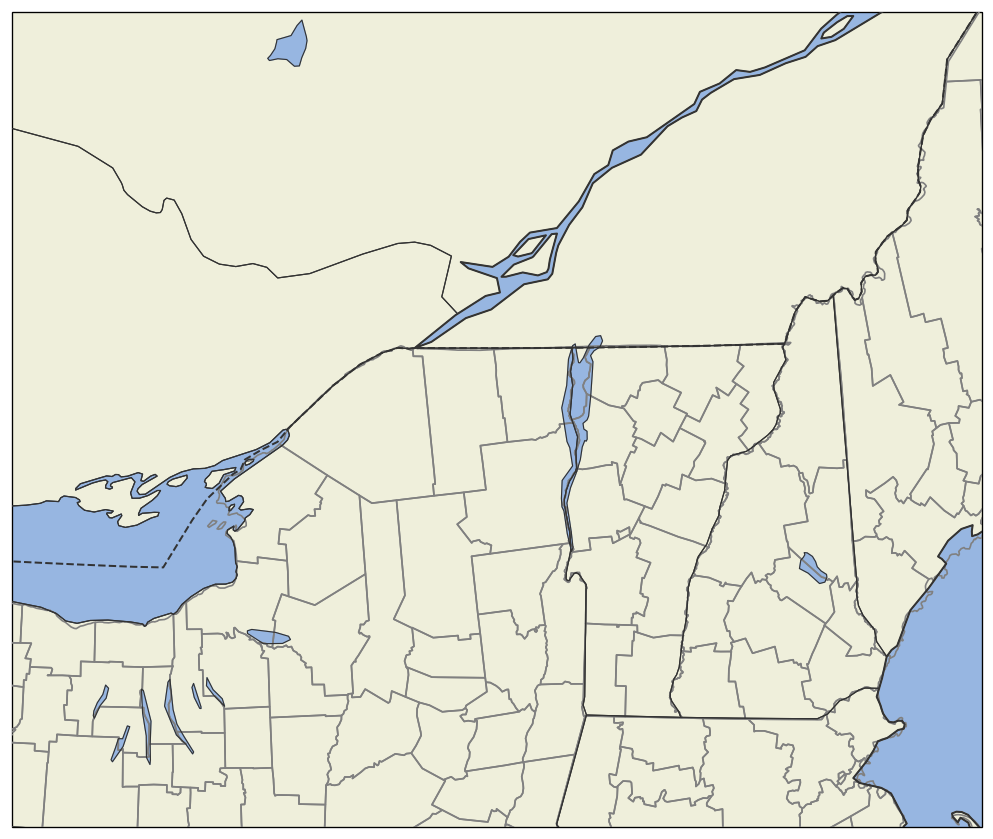

In [4]:
#Example of base (blank) plot for different regions
#Need to specify a plot region and map projection
#Plot region options: olympics, olympics_zoom, cascades, pac_nw,
#msoh_vly, neus, ny, adk_lch_qc, new_england, midatl, carolinas, seus, conus

#CONUS plot using HRRR domain extent/projection
#plot_region = 'conus'

#Mid-Atlantic plot
#plot_region = 'midatl'

#Mississippi/Ohio Valley plot
#plot_region = 'msoh_vly'

#NY/NEUS domain plots
#plot_region = 'ny'
#plot_region = 'neus'

#WINTRE-MIX domain plots
plot_region = 'adk_lch_qc'


#prefer using both filled and outlined lakes except for CONUS
plot_lakes = 'filled' if plot_region == 'conus' else 'both'
fig, ax = plot_geog_single(plot_region = plot_region, geog_color = '0.2', geog_lw = 1.2, plot_lakes = plot_lakes)
#fig, axarr = plot_geog(plot_region = plot_region, geog_color = '0.2', geog_lw = 1.2, plot_lakes = plot_lakes) #9-panel plot

In [5]:
#Define p-type colorbar to be used

#Colorbar I use for HRRR/HRRRE output
#From the categorical individual p-type output, I compute 
#ptype = 8*crain + 4*cfrzr + 2*cicep + 1*csnow to get unique values between 0-15 
#(really 0-11 since RA and ZR are exclusive and can't overlap)
# 0 = NP, 1 = SN, 2 = IP, 3 = IP+SN, 4 = ZR, 5 = ZR+SN, 6 = ZR+IP, 7 = ZR+IP+SN, 8 = RA, 9 = RA+SN, 10 = RA+IP, 11 = RA+IP+SN
ptype_colors = [(1,1,1,0),'tab:blue','mediumslateblue','darkslateblue','mediumvioletred','mediumorchid','darkmagenta','orchid','tab:green','darkturquoise','turquoise','cyan']
cmap_ptype_ext = mpl.colors.ListedColormap(ptype_colors)
norm_ptype_ext = mpl.colors.BoundaryNorm([-1,0,1,2,3,4,5,6,7,8,9,10,11],ncolors = len(ptype_colors))
ptype_ticks = [-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5]
ptype_labels = ['NP','SN','IP','IP/SN','ZR','ZR/SN','ZR/IP','ZR/IP/SN','RA','RA/SN','RA/IP','RA/IP/SN']

#Slightly modified colorbar (changed RA+IP color) and
#removed a few mix types that aren't mPING report options
# 0 = NP, 1 = SN, 2 = IP, 3 = IP+SN, 4 = ZR, 6 = ZR+IP, 8 = RA, 9 = RA+SN, 10 = RA+IP
ptype_colors = [(1,1,1,1),'tab:blue','mediumslateblue','darkslateblue','mediumvioletred','darkmagenta','tab:green','darkturquoise','cyan']
cmap_ptype_ext = mpl.colors.ListedColormap(ptype_colors)
norm_ptype_ext = mpl.colors.BoundaryNorm([-1,0,1,2,3,5,6,8,9,10],ncolors = len(ptype_colors))
ptype_ticks = [-0.5,0.5,1.5,2.5,4,5.5,7,8.5,9.5]
ptype_labels = ['NP','SN','IP','IP/SN','ZR','ZR/IP','RA','RA/SN','RA/IP']

cbar_ptype = mpl.cm.ScalarMappable(norm = norm_ptype_ext, cmap = cmap_ptype_ext)
cbar_ptype.set_array([])

In [6]:
def get_mping_obs(valid_time, interval_min = 60, time_window = 'center'):
    '''Retrieve mPING observations and parse into a pandas DataFrame
    Inputs: 
        valid_time (datetime object) - desired observation time
        interval_min (int) - range of time in minutes to get observations  
        time_window ("begin", "center" or "end") 
            - "begin": get obs for interval_min beginning at valid_time
            - "center": get obs centered on valid_time
            - "end": get obs for interval_min ending at valid_time
    Return:
        pandas DataFrame with nicely parsed obs'''
    
    reqheaders = {
    'content-type': 'application/json',
    'Authorization': f'Token {api_key}',
    }
    
    #Form API query URL
    mping_url_base = 'http://mping.ou.edu/mping/api/v2/reports'
    
    #Add filters to base URL
    if time_window == 'begin':
        #get all reports for time interval beginning at valid time
        mping_start = valid_time
        mping_end = valid_time + timedelta(minutes = interval_min)
        mping_url = f'{mping_url_base}?obtime_gte={mping_start:%Y-%m-%d %H:%M:%S}&obtime_lt={mping_end:%Y-%m-%d %H:%M:%S}'
        #print (mping_url)
        print (f'getting mPING reports from {interval_min} min beginning at {valid_time:%Hz %d %b %Y}')
    elif time_window == 'end':
        #get all reports for 1h preceding valid time
        #mping_valid = valid_time - timedelta(minutes = interval_min)
        #mping_url = f'{mping_url_base}?year={mping_valid:%Y}&month={mping_valid:%-m}&day={mping_valid:%-d}&hour={mping_valid:%-H}'
        
        #get all reports for time interval ending at valid time
        mping_start = valid_time - timedelta(minutes = interval_min)
        mping_end = valid_time
        mping_url = f'{mping_url_base}?obtime_gt={mping_start:%Y-%m-%d %H:%M:%S}&obtime_lte={mping_end:%Y-%m-%d %H:%M:%S}'
        #print (mping_url)
        print (f'getting mPING reports from {interval_min} min ending at {valid_time:%Hz %d %b %Y}')
    elif time_window == 'center':
        #get all reports for time interval centered on valid time
        mping_start = valid_time - timedelta(minutes = interval_min//2)
        mping_end = valid_time + timedelta(minutes = interval_min//2)
        mping_url = f'{mping_url_base}?obtime_gte={mping_start:%Y-%m-%d %H:%M:%S}&obtime_lt={mping_end:%Y-%m-%d %H:%M:%S}'
        #print (mping_url)
        print (f'getting mPING reports from {interval_min} min centered on {valid_time:%Hz %d %b %Y}')
     
    #Retrieve JSON data
    response = requests.get(mping_url, headers = reqheaders)
    if response.status_code != 200:
        print (f'request failed with status code {response.status_code}')
        return
    else:
        data = response.json()
        print (f'retrieved {data["count"]} reports')
    
    #Read mPING json into dataframe for easier filtering
    df = pd.DataFrame.from_dict(data['results'])
    #Parse out lat/lon data
    df['longitude'] = [geom['coordinates'][0] for geom in df['geom']]
    df['latitude'] = [geom['coordinates'][1] for geom in df['geom']]
    
    #could stop here
    #return df
    
    #Also map mPING p-types to p-type values/colors used in colorbar
    mping_types_map = {'NULL': 0,
                      'Snow and/or Graupel': 1,
                      'Ice Pellets/Sleet': 2,
                      'Mixed Ice Pellets and Snow': 3,
                      'Freezing Rain': 4,
                      'Freezing Drizzle': 4, #don't have separate category for this currently
                      'Mixed Freezing Rain and Ice Pellets': 6,
                      'Rain': 8, 
                      'Drizzle': 8, #don't have separate category for this
                      'Mixed Rain and Snow': 9,
                      'Mixed Rain and Ice Pellets': 10,
                      }
    #map indexes to colors (optional: only works if continuous value HRRRE colorbar used)
    #mping_colors_map = {k:ptype_colors[int(v)] for k,v in mping_types_map.items()}
    
    #Subtract 0.01 to make p-type categories correct
    df['ptype'] = df['description'].map(mping_types_map) - 0.01
    #df['ptype_colors'] = df['description'].map(mping_colors_map)
    
    return df

In [7]:
#Pick a valid time and download 2h of mPING obs ending at that time
valid_time = datetime(2022,1,16,14)
df = get_mping_obs(valid_time, interval_min = 120, time_window = 'end')

getting mPING reports from 120 min ending at 14z 16 Jan 2022
retrieved 1389 reports


In [8]:
#View reports
C = Counter(df['description'].values)
print (C)
df

Counter({'Snow and/or Graupel': 486, 'Ice Pellets/Sleet': 227, 'Rain': 162, 'Freezing Rain': 120, 'Mixed Ice Pellets and Snow': 102, 'NULL': 68, 'Mixed Rain and Snow': 52, 'Mixed Freezing Rain and Ice Pellets': 41, 'Lawn furniture or trash cans displaced; Small twigs broken': 35, 'Drizzle': 33, 'Mixed Rain and Ice Pellets': 21, 'Freezing Drizzle': 18, 'Blowing Snow': 7, '1-inch tree limbs broken; Shingles blown off': 6, 'Dense Fog': 5, '3-inch tree limbs broken; Power poles broken': 4, 'River/Creek overflowing; Cropland/Yard/Basement Flooding': 1, 'Snow Squall': 1})


,id,obtime,category,description,description_id,geom,longitude,latitude,ptype
0,2965438,2022-01-16T12:00:21Z,Rain/Snow,Mixed Rain and Snow,9,"{'type': 'Point', 'coordinates': [-84.06818552...",-84.068186,34.053405,8.99
1,2965439,2022-01-16T12:00:23Z,Rain/Snow,Freezing Rain,4,"{'type': 'Point', 'coordinates': [-79.846467, ...",-79.846467,34.264243,3.99
2,2965440,2022-01-16T12:00:38Z,Rain/Snow,Rain,3,"{'type': 'Point', 'coordinates': [-83.28962329...",-83.289623,34.023706,7.99
3,2965441,2022-01-16T12:00:39Z,Rain/Snow,Ice Pellets/Sleet,7,"{'type': 'Point', 'coordinates': [-78.86047960...",-78.860480,35.766845,1.99
4,2965442,2022-01-16T12:00:50Z,Rain/Snow,Snow and/or Graupel,8,"{'type': 'Point', 'coordinates': [-92.0184978,...",-92.018498,33.814717,0.99
...,...,...,...,...,...,...,...,...,...
1384,2966822,2022-01-16T13:59:40Z,Rain/Snow,Snow and/or Graupel,8,"{'type': 'Point', 'coordinates': [-81.32760248...",-81.327602,35.645448,0.99
1385,2966823,2022-01-16T13:59:47Z,Rain/Snow,Rain,3,"{'type': 'Point', 'coordinates': [-84.5596113,...",-84.559611,34.100587,7.99
1386,2966824,2022-01-16T13:59:49Z,None,NULL,2,"{'type': 'Point', 'coordinates': [-80.13659928...",-80.136599,40.595863,-0.01
1387,2966825,2022-01-16T13:59:49Z,Rain/Snow,Ice Pellets/Sleet,7,"{'type': 'Point', 'coordinates': [-80.6892596,...",-80.689260,35.741490,1.99


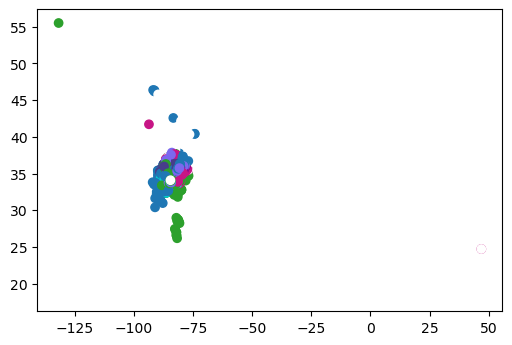

In [9]:
#Quick plot of all obs locations
#fig, ax = plt.subplots(dpi = 100)
#plt.plot(df['longitude'], df['latitude'],'o')

#Quick plot of p-type
fig, ax = plt.subplots(dpi = 100)
plt.scatter(df['longitude'], df['latitude'], c = df['ptype'], cmap = cmap_ptype_ext, norm = norm_ptype_ext)

getting mPING reports from 120 min ending at 14z 16 Jan 2022
retrieved 1389 reports


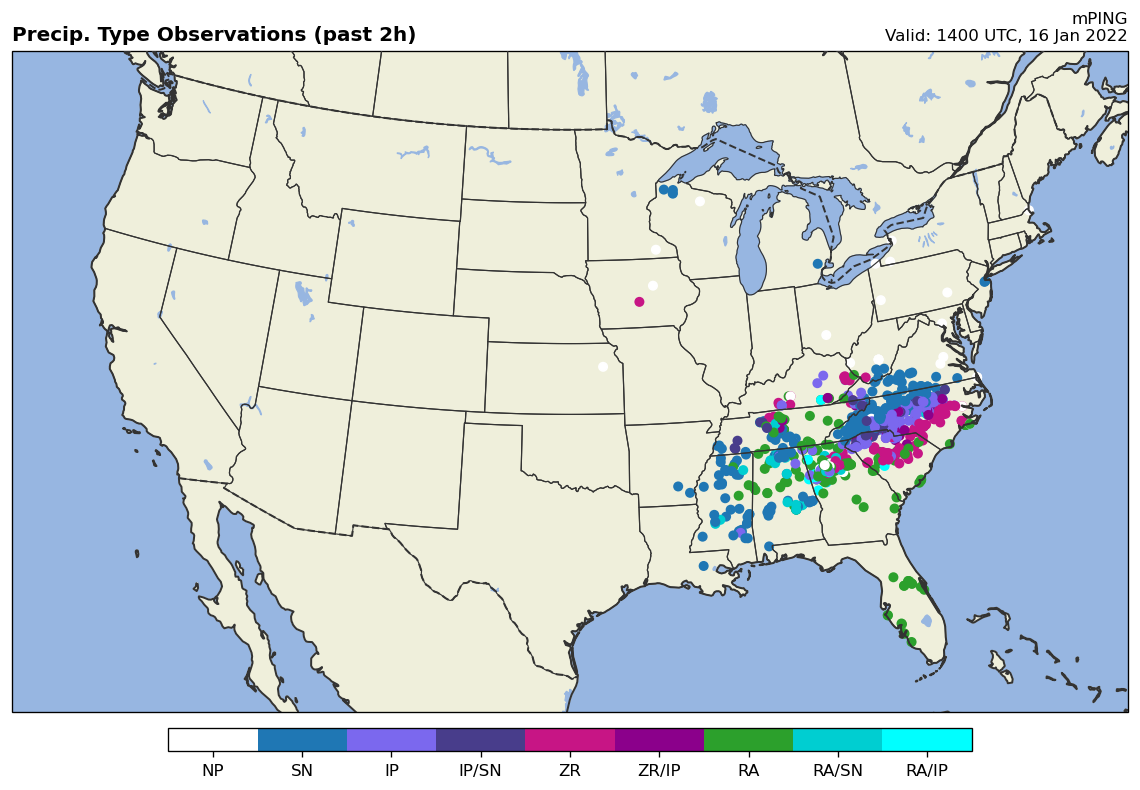

In [10]:
#Make plot of mPING observations over a specified time window
valid_time = datetime(2022,1,16,14)
interval_hrs = 2 #length of time to plot

#Get 2h of mPING obs ending at valid_time
df = get_mping_obs(valid_time, interval_min = interval_hrs*60, time_window = 'end')

plot_region = 'conus'

#prefer using both filled and outlined lakes except for CONUS
plot_lakes = 'filled' if plot_region == 'conus' else 'both'
fig, ax = plot_geog_single(plot_region = plot_region, geog_color = '0.2', geog_lw = 1.2, plot_lakes = plot_lakes)

#Plot mPING obs using p-type colorbar defined above
msize = 25 if plot_region == 'conus' else 50
ax.scatter(df['longitude'], df['latitude'], s = msize, c = df['ptype'], cmap = cmap_ptype_ext, norm = norm_ptype_ext, 
           transform = ccrs.PlateCarree(), zorder = 2)

cbar = plt.colorbar(cbar_ptype, orientation = 'horizontal', ticks = ptype_ticks, shrink = 0.72, pad = 0.02, aspect = 35)
cbar.ax.set_xticklabels(ptype_labels)

font_size = 12
vars_str = f'Precip. Type Observations (past {interval_hrs}h)'
ax.set_title(vars_str, loc = 'left', fontsize = font_size, fontweight = 'bold')
model_str = f'mPING\nValid: {valid_time:%H%M UTC, %d %b %Y}'
ax.set_title(model_str, loc = 'right', fontsize = font_size-2)
plt.savefig(imgdir+f'{var_name}_reports_past{interval_hrs}h_{plot_region}_{valid_time:%Y%m%d%H}.png', bbox_inches = 'tight')

In [11]:
#Make several plots of mPING observations over a specified time window
init_time = datetime(2022,1,16,10) #first time to plot
interval_hrs = 2 #length of time to plot
plot_hours = range(0,9,2)

plot_region = 'carolinas'

for hr in plot_hours:
    valid_time = init_time + timedelta(hours = hr)
    print (f'plotting {valid_time:%Hz %d %b %Y}')
    #Get mPING obs ending at valid_time
    df = get_mping_obs(valid_time, interval_min = interval_hrs*60, time_window = 'end')

    #recommend using both filled and outlined lakes except for CONUS
    plot_lakes = 'filled' if plot_region == 'conus' else 'both'
    fig, ax = plot_geog_single(plot_region = plot_region, geog_color = '0.2', geog_lw = 1.2, plot_lakes = plot_lakes)

    #Plot mPING obs using p-type colorbar defined above
    msize = 25 if plot_region == 'conus' else 50
    ax.scatter(df['longitude'], df['latitude'], s = msize, c = df['ptype'], cmap = cmap_ptype_ext, norm = norm_ptype_ext, 
               transform = ccrs.PlateCarree(), zorder = 2)

    cbar = plt.colorbar(cbar_ptype, orientation = 'horizontal', ticks = ptype_ticks, shrink = 0.72, pad = 0.02, aspect = 35)
    cbar.ax.set_xticklabels(ptype_labels)

    font_size = 12
    vars_str = f'Precip. Type Observations (past {interval_hrs}h)'
    ax.set_title(vars_str, loc = 'left', fontsize = font_size, fontweight = 'bold')
    model_str = f'mPING\nValid: {valid_time:%H%M UTC, %d %b %Y}'
    ax.set_title(model_str, loc = 'right', fontsize = font_size-2)
    plt.savefig(imgdir+f'{var_name}_reports_past{interval_hrs}h_{plot_region}_{valid_time:%Y%m%d%H}.png', bbox_inches = 'tight')
    plt.close()

plotting 10z 16 Jan 2022
getting mPING reports from 120 min ending at 10z 16 Jan 2022
retrieved 340 reports
plotting 12z 16 Jan 2022
getting mPING reports from 120 min ending at 12z 16 Jan 2022
retrieved 572 reports
plotting 14z 16 Jan 2022
getting mPING reports from 120 min ending at 14z 16 Jan 2022
retrieved 1389 reports
plotting 16z 16 Jan 2022
getting mPING reports from 120 min ending at 16z 16 Jan 2022
retrieved 2398 reports
plotting 18z 16 Jan 2022
getting mPING reports from 120 min ending at 18z 16 Jan 2022
retrieved 1700 reports
